## All Model code development

### Northwestern Banking

#### Loan prediction project
##### Updated 10-25-2020 Lescher

In [1]:
#initiate libaray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import statsmodels.api as sms
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import pickle


In [2]:
#desktop code
datapath = os.path
df = pd.read_csv("modelingdftrain.csv",  sep=',')

### Declare all functions here

#### error metrics and confusion matrix graphs

In [3]:
#function to return accuracy measure & confusion matrix, 
#just enter in y predictions, title of model and the model object
#since y_test values don't change
def graph_metrics(y_pred, title, model):
    #confusion matrix that's been normalized
    fig = plt.figure( )
    confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'],normalize=True)
    sns.heatmap(confusion_matrix, annot=True)
    plt.title(title)
    plt.xticks(np.arange(0.5,2), ['Paid', 'Default'])
    plt.yticks(np.arange(0.5,2), ['Paid', 'Default'])
    plt.show()
    fig.savefig(title + " Con Mat", bbox_inches='tight', dpi=250)

    #roc
    fig = plt.figure( )
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="ROC, auc="+str(auc))
    plt.legend(loc=4)
    plt.title(title+ " ROC")
    plt.show()
    fig.savefig(title + " ROC", bbox_inches='tight', dpi=250)

    #gives us Accuracy Rsquared, MAE, MSE, RMSE and more    
    explained_variance=metrics.explained_variance_score(y_test, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_test, y_pred) 
    mse=metrics.mean_squared_error(y_test, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_test, y_pred)
    r2=metrics.r2_score(y_test, y_pred)    
    
    tnc, tpc, fnc, fpc = cost_err(y_pred)
    
    return [title, metrics.accuracy_score(y_test, y_pred), round(explained_variance,4),
                         round(mean_squared_log_error,4), round(r2,4), round(mean_absolute_error,4), 
                         round(mse,4), round(np.sqrt(mse),4), auc, 
                         confusion_matrix[0][0], confusion_matrix[1][1], confusion_matrix[0][1], confusion_matrix[1][0],
                         tnc, tpc, fnc, fpc]

#### function to define the cost related error for each model

In [4]:
def cost_err(y_pred):
    costdf = y_test1
    costdf['pred_ind'] = y_pred
    costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
    
    costdf['True_Neg_Cost'] = 0
    costdf['True_Pos_Cost'] = 0
    costdf['False_Neg_Cost'] = 0
    costdf['False_Pos_Cost'] = 0
    costdf.loc[(costdf['default_ind']==0) & (costdf['pred_ind']==0), 'True_Neg_Cost'] = costdf['loan_amnt']
    costdf.loc[(costdf['default_ind']==1) & (costdf['pred_ind']==1), 'True_Pos_Cost'] = costdf['loan_amnt']
    costdf.loc[(costdf['default_ind']==1) & (costdf['pred_ind']==0), 'False_Neg_Cost'] = costdf['loan_amnt']
    costdf.loc[(costdf['default_ind']==0) & (costdf['pred_ind']==1), 'False_Pos_Cost'] = costdf['loan_amnt']
    
    
    return [costdf['True_Neg_Cost'].sum(), costdf['True_Pos_Cost'].sum(), 
            costdf['False_Neg_Cost'].sum(), costdf['False_Pos_Cost'].sum()]

#### function used to return the columns used in an RFE model

In [5]:
def cols_used(model):
    d = []
    for i in range(X_train.shape[1]):
        d.append(
            {
                'Feature': X_train.columns[i],
                'Used': model.support_[i],
                'Rank':  model.ranking_[i]
                }
            )
    return pd.DataFrame(d)

### data and results prep

In [6]:
#this is our comparison dataframe to judge all models on
#True Negative is when we accurately predict someone will pay off their loan
#True Pos is when we accurately predict someone will default
#False Neg is when we believe someone will pay off their loan but they don't
#False Pos is when we believe someone will default but they don't
resultcols = ['Model', 'Accuracy', 'explained_variance','mean_squared_log_error', 'r2', 'MAE', 'MSE', 'RMSE',
              'AUC','True_Neg', 'True_Pos', 'False_Neg', 'False_Pos',
              'True_Neg_Cost', 'True_Pos_Cost', 'False_Neg_Cost', 'False_Pos_Cost']
resultsdf = pd.DataFrame(columns=resultcols)

In [7]:
#this is the full modeling file once we fix the data issues
X = df[['id','loan_amnt_cuberoot', 'term', 'int_rate_log', 'grade', 
              'emp_length2', 'home_ownership2', 'annual_inc_cuberoot', 
              'desc2', 'purpose', 'dti_cube', 'delinq_2yrs', 
              'revol_util', 'initial_list_status2', 'application_type', 
              'tot_coll_amt', 'chargeoff_within_12_mths', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 
              'total_bal_ex_mort', 'delinq_amt_pct', 
              'sats_pct', 'max_fico_low','len_credit_cuberoot' ]]


#target value
y = df[['id','default_ind']]

In [8]:
#process to convert variables to codes from categorical
#might consider putting this into the data prep master
convertlist = ['purpose', 'term', 'application_type', 'grade']
for c in range(0,len(convertlist)):
    X[convertlist[c]] = X[convertlist[c]].astype('category')
    X[convertlist[c]] = X[convertlist[c]].cat.codes

<ipython-input-8-f6d1a6325523>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[convertlist[c]] = X[convertlist[c]].astype('category')
<ipython-input-8-f6d1a6325523>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[convertlist[c]] = X[convertlist[c]].cat.codes


In [9]:
#split the data into test and train sets
X_train1,X_test1,y_train1,y_test1 = train_test_split(X,y,test_size=0.25,random_state=13)

X_train = X_train1.drop(['id'], axis=1)
X_test = X_test1.drop(['id'], axis=1)
y_train = y_train1.drop(['id'], axis=1)
y_test = np.array(y_test1['default_ind'].to_list())

#### SMOTE

In [10]:
sm = SMOTE(random_state=13)
columns = X_train.columns
X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train, y_train)
X_train_SMOTE = pd.DataFrame(data=X_train_SMOTE,columns=columns )
y_train_SMOTE= pd.DataFrame(data=y_train_SMOTE,columns=['default_ind'])

#show how smote works
print("Number of original no default",len(y_train[y_train==0]))
print("Number of original default",len(y_train[y_train==1]))
print("Proportion of original no default is ",len(y_train[y_train==0])/len(X_train))
print("Proportion of original default is ",len(y_train[y_train==1])/len(X_train))

print("length of oversampled data is ",len(X_train_SMOTE))
print("Number of no default",len(y_train_SMOTE[y_train_SMOTE['default_ind']==0]))
print("Number of default",len(y_train_SMOTE[y_train_SMOTE['default_ind']==1]))
print("Proportion of no default is ",len(y_train_SMOTE[y_train_SMOTE['default_ind']==0])/len(X_train_SMOTE))
print("Proportion of default is ",len(y_train_SMOTE[y_train_SMOTE['default_ind']==1])/len(X_train_SMOTE))

Number of original no default 196497
Number of original default 196497
Proportion of original no default is  1.0
Proportion of original default is  1.0
length of oversampled data is  315002
Number of no default 157501
Number of default 157501
Proportion of no default is  0.5
Proportion of default is  0.5


### Models

#### Logistic Regression

C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


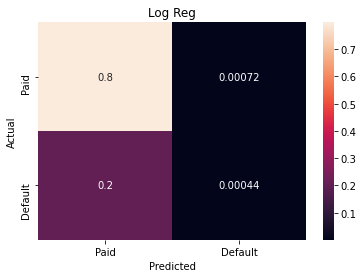

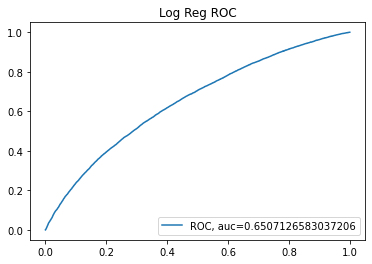

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [11]:
model1 = LogisticRegression(max_iter=10000)
model1.fit(X_train,y_train)
y_pred1=model1.predict(X_test)


#reuse this line to append the results of your model to the results df 
#replace the following
#y_pred1 -> results of your predictions
#'Log reg' -> the title of the graphs and model type
#model1 -> what the model is stored as
resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred1,'Log Reg', model1), index= resultcols), ignore_index=True)
y_test1['log'] = y_pred1

#### Logistic Regression w/ SMOTE

C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


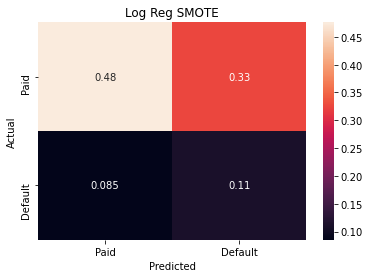

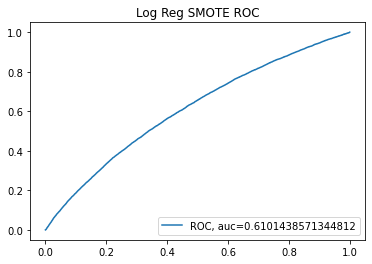

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [12]:
#with  SMOTE
model1_SMOTE = LogisticRegression(max_iter=10000)
model1_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)
y_pred1_SMOTE=model1_SMOTE.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred1_SMOTE,'Log Reg SMOTE', model1_SMOTE), index= resultcols), ignore_index=True)
y_test1['log_smote'] = y_pred1_SMOTE

#### Logistic Regression w/ RFE

C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

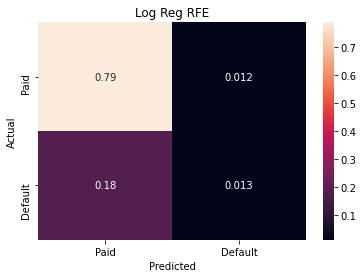

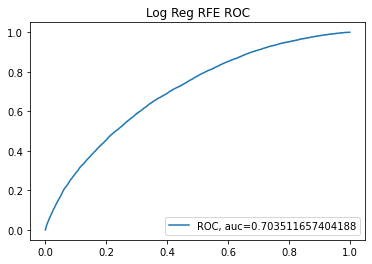

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [13]:
#RFE
model2 = LogisticRegression(max_iter=10000)
rfe = RFECV(model2, n_jobs=10)
rfe.fit(X_train,y_train)
y_pred2=rfe.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred2,'Log Reg RFE', rfe), index= resultcols), ignore_index=True)
y_test1['log_REF'] = y_pred2
rfe_vars = cols_used(rfe)

#### Logistic Regression w/ RFE & SMOTE

C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\clesc\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

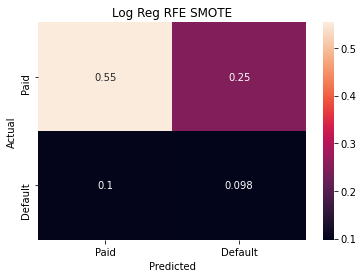

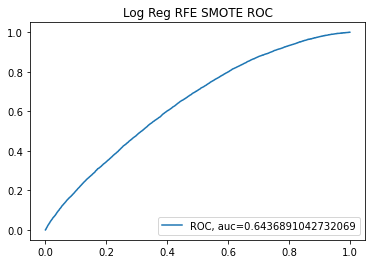

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [14]:
#RFE with SMOTE
model2_SMOTE = LogisticRegression(max_iter=10000)
rfe_SMOTE = RFECV(model2_SMOTE, n_jobs=10)
rfe_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)
y_pred2_SMOTE=rfe_SMOTE.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred2_SMOTE,'Log Reg RFE SMOTE', rfe_SMOTE), index= resultcols), ignore_index=True)
y_test1['log_REF_SMOTE'] = y_pred2_SMOTE
rfe_SMOTE_vars = cols_used(rfe_SMOTE)

#### Decision Tree

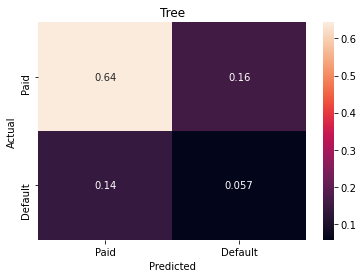

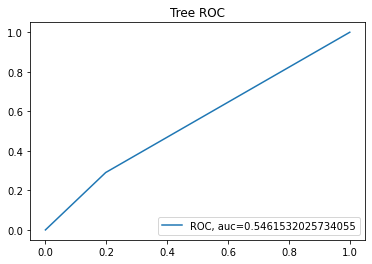

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [15]:
#decision tree
model3 = DecisionTreeClassifier()
model3 = model3.fit(X_train,y_train)
y_pred3 = model3.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred3,'Tree', model3), index= resultcols), ignore_index=True)
y_test1['Tree'] = y_pred3

#### Decision Tree w/ SMOTE

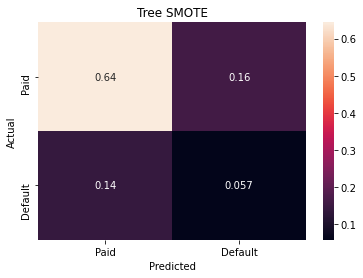

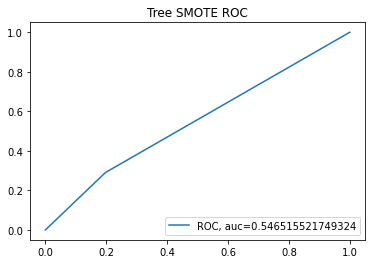

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [16]:
#tree with SMOTE
model3_SMOTE = DecisionTreeClassifier()
model3_SMOTE = model3_SMOTE.fit(X_train,y_train)
y_pred3_SMOTE = model3_SMOTE.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred3_SMOTE,'Tree SMOTE', model3_SMOTE), index= resultcols), ignore_index=True)
y_test1['Tree_SMOTE'] = y_pred3_SMOTE

#### Decision Tree w/ RFE

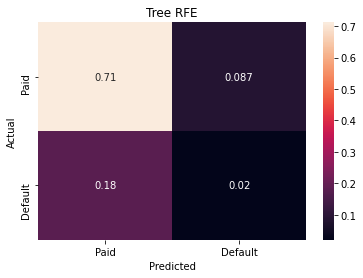

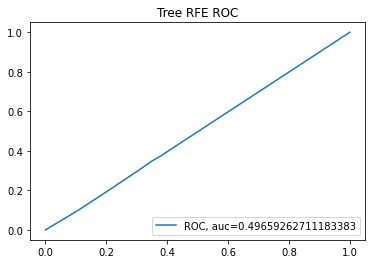

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [12]:
#RFEtree
model4 = DecisionTreeClassifier()
rfe2 = RFECV(model4, n_jobs=10)
rfe2.fit(X_train,y_train)
y_pred4=rfe2.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred4,'Tree RFE', rfe2), index= resultcols), ignore_index=True)
y_test1['Tree_RFE'] = y_pred4
rfe2_vars = cols_used(rfe2)

#### Decision Tree w/ RFE & SMOTE

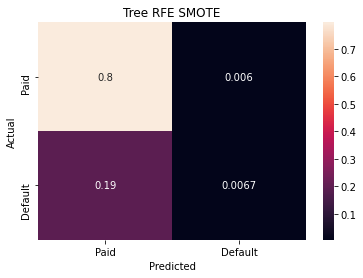

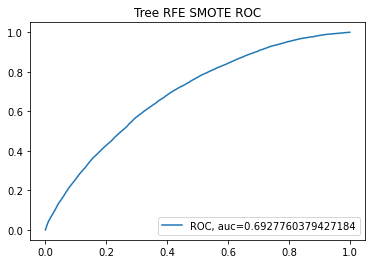

<ipython-input-4-c11f19516e14>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['pred_ind'] = y_pred
<ipython-input-4-c11f19516e14>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  costdf['loan_amnt'] = X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
<ipython-input-4-c11f19516e14>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [18]:
#RFE with SMOTE
model4_SMOTE = DecisionTreeClassifier()
rfe2_SMOTE = RFECV(model4_SMOTE, n_jobs=10)
rfe2_SMOTE.fit(X_train_SMOTE,y_train_SMOTE)
y_pred4_SMOTE=rfe2_SMOTE.predict(X_test)

resultsdf=resultsdf.append(pd.Series(graph_metrics(y_pred4_SMOTE,'Tree RFE SMOTE', rfe2_SMOTE), index= resultcols), ignore_index=True)
y_test1['Tree_RFE_SMOTE'] = y_pred4_SMOTE
rfe2_SMOTE_vars = cols_used(rfe2_SMOTE)

### Value Models

In [19]:
df =  pd.read_csv('modelingdfvalue.csv', sep=','  , engine='python')
#data prep
val_X = df[['id','loan_amnt_cuberoot', 'term', 'int_rate_log', 'grade', 
              'emp_length2', 'home_ownership2', 'annual_inc_cuberoot', 
              'desc2', 'purpose', 'dti_cube', 'delinq_2yrs', 
              'revol_util', 'initial_list_status2', 'application_type', 
              'tot_coll_amt', 'chargeoff_within_12_mths', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 
              'total_bal_ex_mort', 'delinq_amt_pct', 
              'sats_pct', 'max_fico_low','len_credit_cuberoot' ]]


#target value
val_y = df[['id','total_pymnt']]

#process to convert variables to codes from categorical
#might consider putting this into the data prep master
for c in range(0,len(convertlist)):
    val_X[convertlist[c]] = val_X[convertlist[c]].astype('category')
    val_X[convertlist[c]] = val_X[convertlist[c]].cat.codes

<ipython-input-19-eca88b4d0f86>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X[convertlist[c]] = val_X[convertlist[c]].astype('category')
<ipython-input-19-eca88b4d0f86>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_X[convertlist[c]] = val_X[convertlist[c]].cat.codes


In [20]:
#split the data into test and train sets
val_X_train1,val_X_test1,val_y_train1,val_y_test1 = train_test_split(val_X,val_y,test_size=0.25,random_state=13)

val_X_train = val_X_train1.drop(['id'], axis=1)
val_X_test = val_X_test1.drop(['id'], axis=1)
val_y_train = val_y_train1.drop(['id'], axis=1)
val_y_test = np.array(val_y_test1['total_pymnt'].to_list())

#### Linear Regression

In [21]:
val_model1 = LinearRegression()
val_model1.fit(val_X_train,val_y_train)
val_y_pred1=val_model1.predict(X_test)
y_test1['Linear_Val'] = val_y_pred1

<ipython-input-21-b659278996f3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['Linear_Val'] = val_y_pred1


#### Linear Regression RFE

In [22]:
val_model2 = LinearRegression()
val_rfe = RFECV(val_model2, n_jobs=10)
val_rfe.fit(val_X_train,val_y_train)
val_y_pred2=val_rfe.predict(X_test)

y_test1['Linear_REF_Val'] = val_y_pred2

<ipython-input-22-d213b8d37752>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['Linear_REF_Val'] = val_y_pred2


#### Simple Average recovery rate

In [23]:
val_y_pred3=.5*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']*X_test['loan_amnt_cuberoot']
y_test1['45_pct_Val'] = val_y_pred3


<ipython-input-23-62e311eeefb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test1['45_pct_Val'] = val_y_pred3


### Results saving

In [24]:
#comparison table of model error metrics
resultsdf.to_csv('modelresults.csv') 

In [25]:
#prediction values
y_test1.to_csv('predictionvalues.csv')

In [1]:
# save the models to disk


pickle.dump(model1, open('model1.sav', 'wb'))
pickle.dump(model1_SMOTE, open('model1_SMOTE.sav', 'wb'))
pickle.dump(rfe, open('rfe.sav', 'wb'))
pickle.dump(rfe_SMOTE, open('rfe_SMOTE.sav', 'wb'))
pickle.dump(model3, open('model3.sav', 'wb'))
pickle.dump(model3_SMOTE, open('model3_SMOTE.sav', 'wb'))
pickle.dump(rfe2, open('rfe2.sav', 'wb'))
pickle.dump(rfe2_SMOTE, open('rfe2_SMOTE.sav', 'wb'))



pickle.dump(val_model1, open('val_model1.sav', 'wb'))
pickle.dump(val_rfe, open('val_rfe.sav', 'wb'))


NameError: name 'pickle' is not defined

In [13]:
print(rfe2_vars)
pickle.dump(rfe2, open('rfe2.sav', 'wb'))

                     Feature   Used  Rank
0         loan_amnt_cuberoot  False     7
1                       term  False    19
2               int_rate_log  False     5
3                      grade  False     8
4                emp_length2  False    11
5            home_ownership2  False    18
6        annual_inc_cuberoot  False     6
7                      desc2  False    20
8                    purpose  False    12
9                   dti_cube  False     2
10               delinq_2yrs  False    14
11                revol_util  False     4
12      initial_list_status2  False    16
13          application_type  False    21
14              tot_coll_amt  False    13
15  chargeoff_within_12_mths  False    22
16            pct_tl_nvr_dlq  False     9
17      pub_rec_bankruptcies  False    15
18         total_bal_ex_mort   True     1
19            delinq_amt_pct  False    23
20                  sats_pct  False    17
21              max_fico_low  False    10
22       len_credit_cuberoot  Fals